# Longtogeny

In [6]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from aging.behavior.syllables import relabel_by_usage, assign_onsets

In [75]:
# very noisy session
exclude_dates = [pd.Timestamp("2021-10-16 17:00:57")]

In [46]:
pat = re.compile(r"long[-]?(\d).*[-_](nt|rl|r|l)")
tag_map = dict(r=2, l=3, nt=1, rl=4)


def mouse_map(string):
    """returns mouse identity"""
    match = pat.search(string)
    if match is None:
        # remove the c##_m## mice
        if "c" in string and "m" in string:
            return ""
        return string[:5]
    else:
        cage = int(match.group(1))
        _id = tag_map[match.group(2)]
        return f"{cage:02d}_{_id:02d}"

In [9]:
data_folder = Path("/n/groups/datta/win/longtogeny/data/ontogeny/version_05")
path = data_folder / "longtogeny_males_syllable_df_v00.parquet"
df = pd.read_parquet(path)


## get syllable maps from male ontogeny
def get_usage_map():
    _, usage_map = relabel_by_usage(
        pd.read_parquet(data_folder / "ontogeny_males_syllable_df_v00.parquet"),
        return_map=True,
    )
    return usage_map


df = assign_onsets(df)
df["relabeled_syllables"] = (
    df["syllables"].map(get_usage_map()).astype("int16[pyarrow]")
)

In [10]:
# calculate age for males
first = pd.Timestamp(year=2021, month=3, day=30)
age = (df.date - first).dt.days + 21
df.age = age
df["age"] = df["age"].astype("int32[pyarrow]")

## manual curations

In [51]:
# replace a time stamp where mouse 04_03 is accidently marked as 03_03
t1 = pd.Timestamp("2021-04-03 17:46:45")
df.loc[df.date == t1, "subject_name"] = "04_03_025"

In [52]:
# remove session copies that i think are females - and save in a diff dataframe
# have the same date but different sessions number - 60 instead of 102

fsessions = [
    pd.Timestamp("2021-10-01 15:47:32"),
    pd.Timestamp("2021-10-01 16:46:10"),
    pd.Timestamp("2021-10-01 17:22:43"),
    pd.Timestamp("2021-10-01 16:17:56"),
    pd.Timestamp("2021-10-01 17:50:37"),
]
extra_females = df[df.date.isin(fsessions)]
extra_females.to_parquet(
    data_folder / "longtogeny_extra_females.parquet", engine="pyarrow"
)

In [53]:
session_length = df.groupby("uuid", sort=False)["timestamps"].max()

In [54]:
keep_uuids = session_length[session_length.between(600, 1250)].index
df = df[~df.date.isin(fsessions) & df["uuid"].isin(keep_uuids)].copy()

<Axes: >

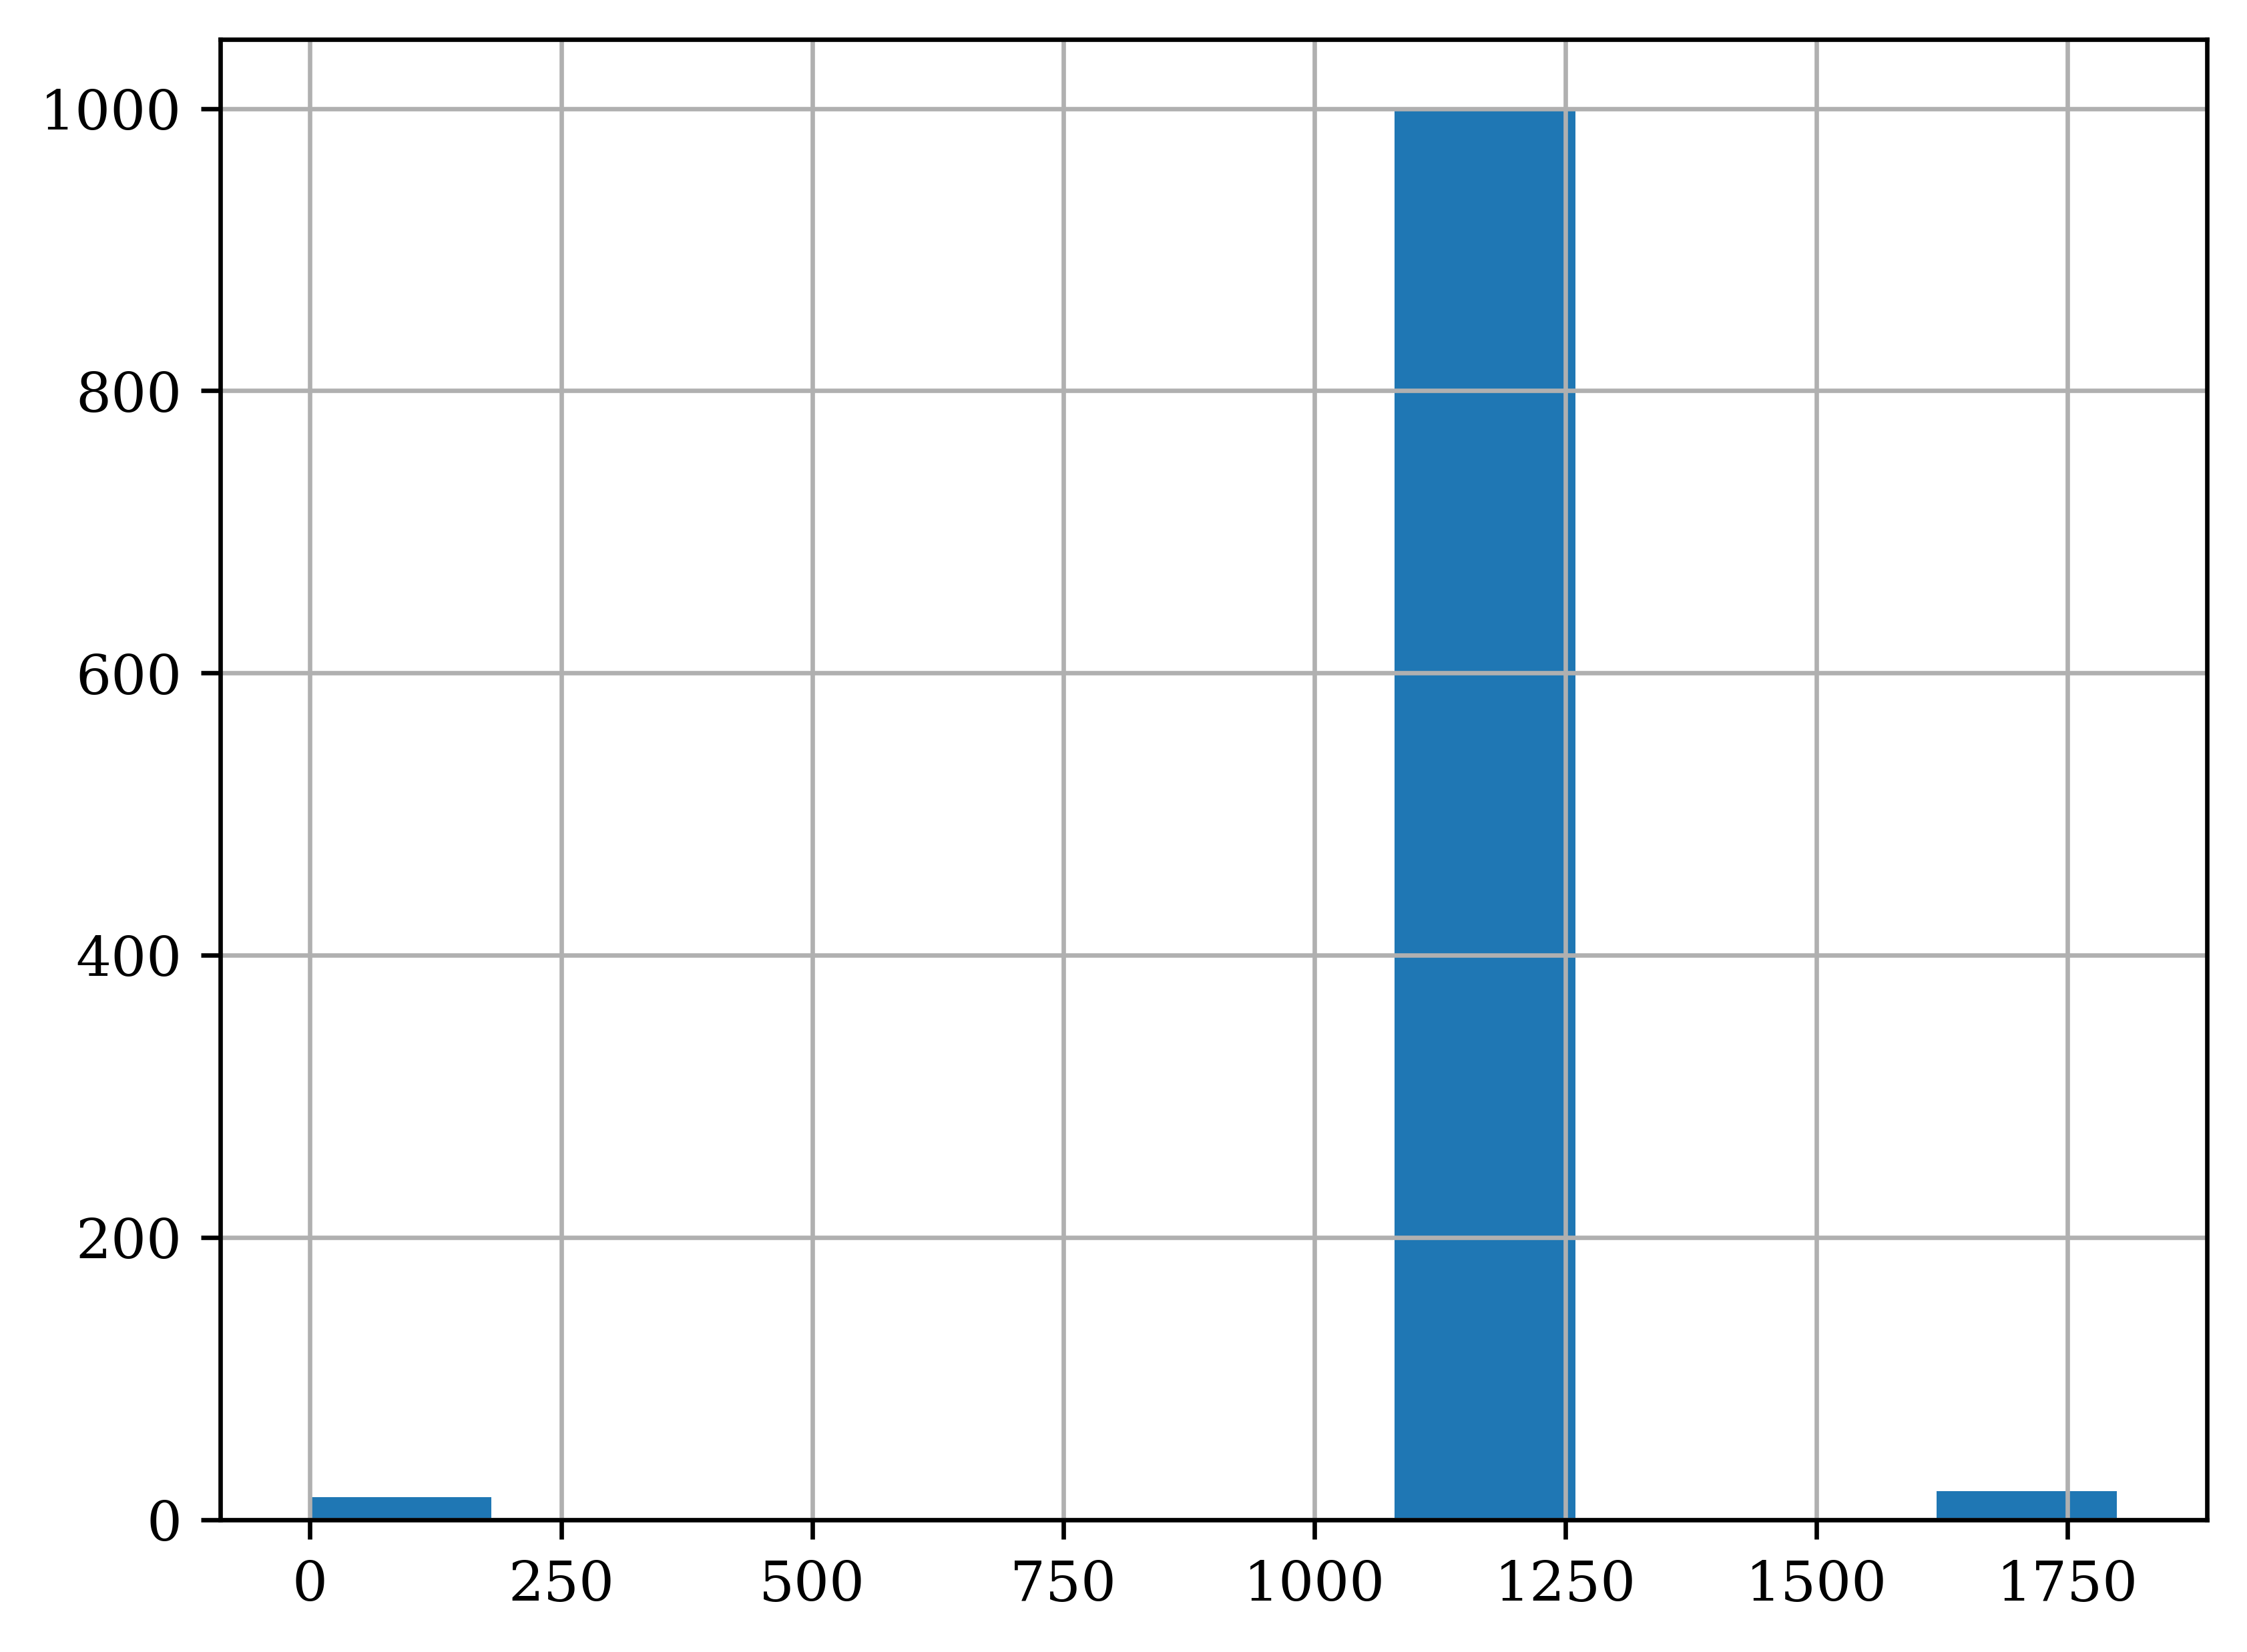

In [11]:
# clean up the data by removing short sessions
session_length.hist()

<Axes: >

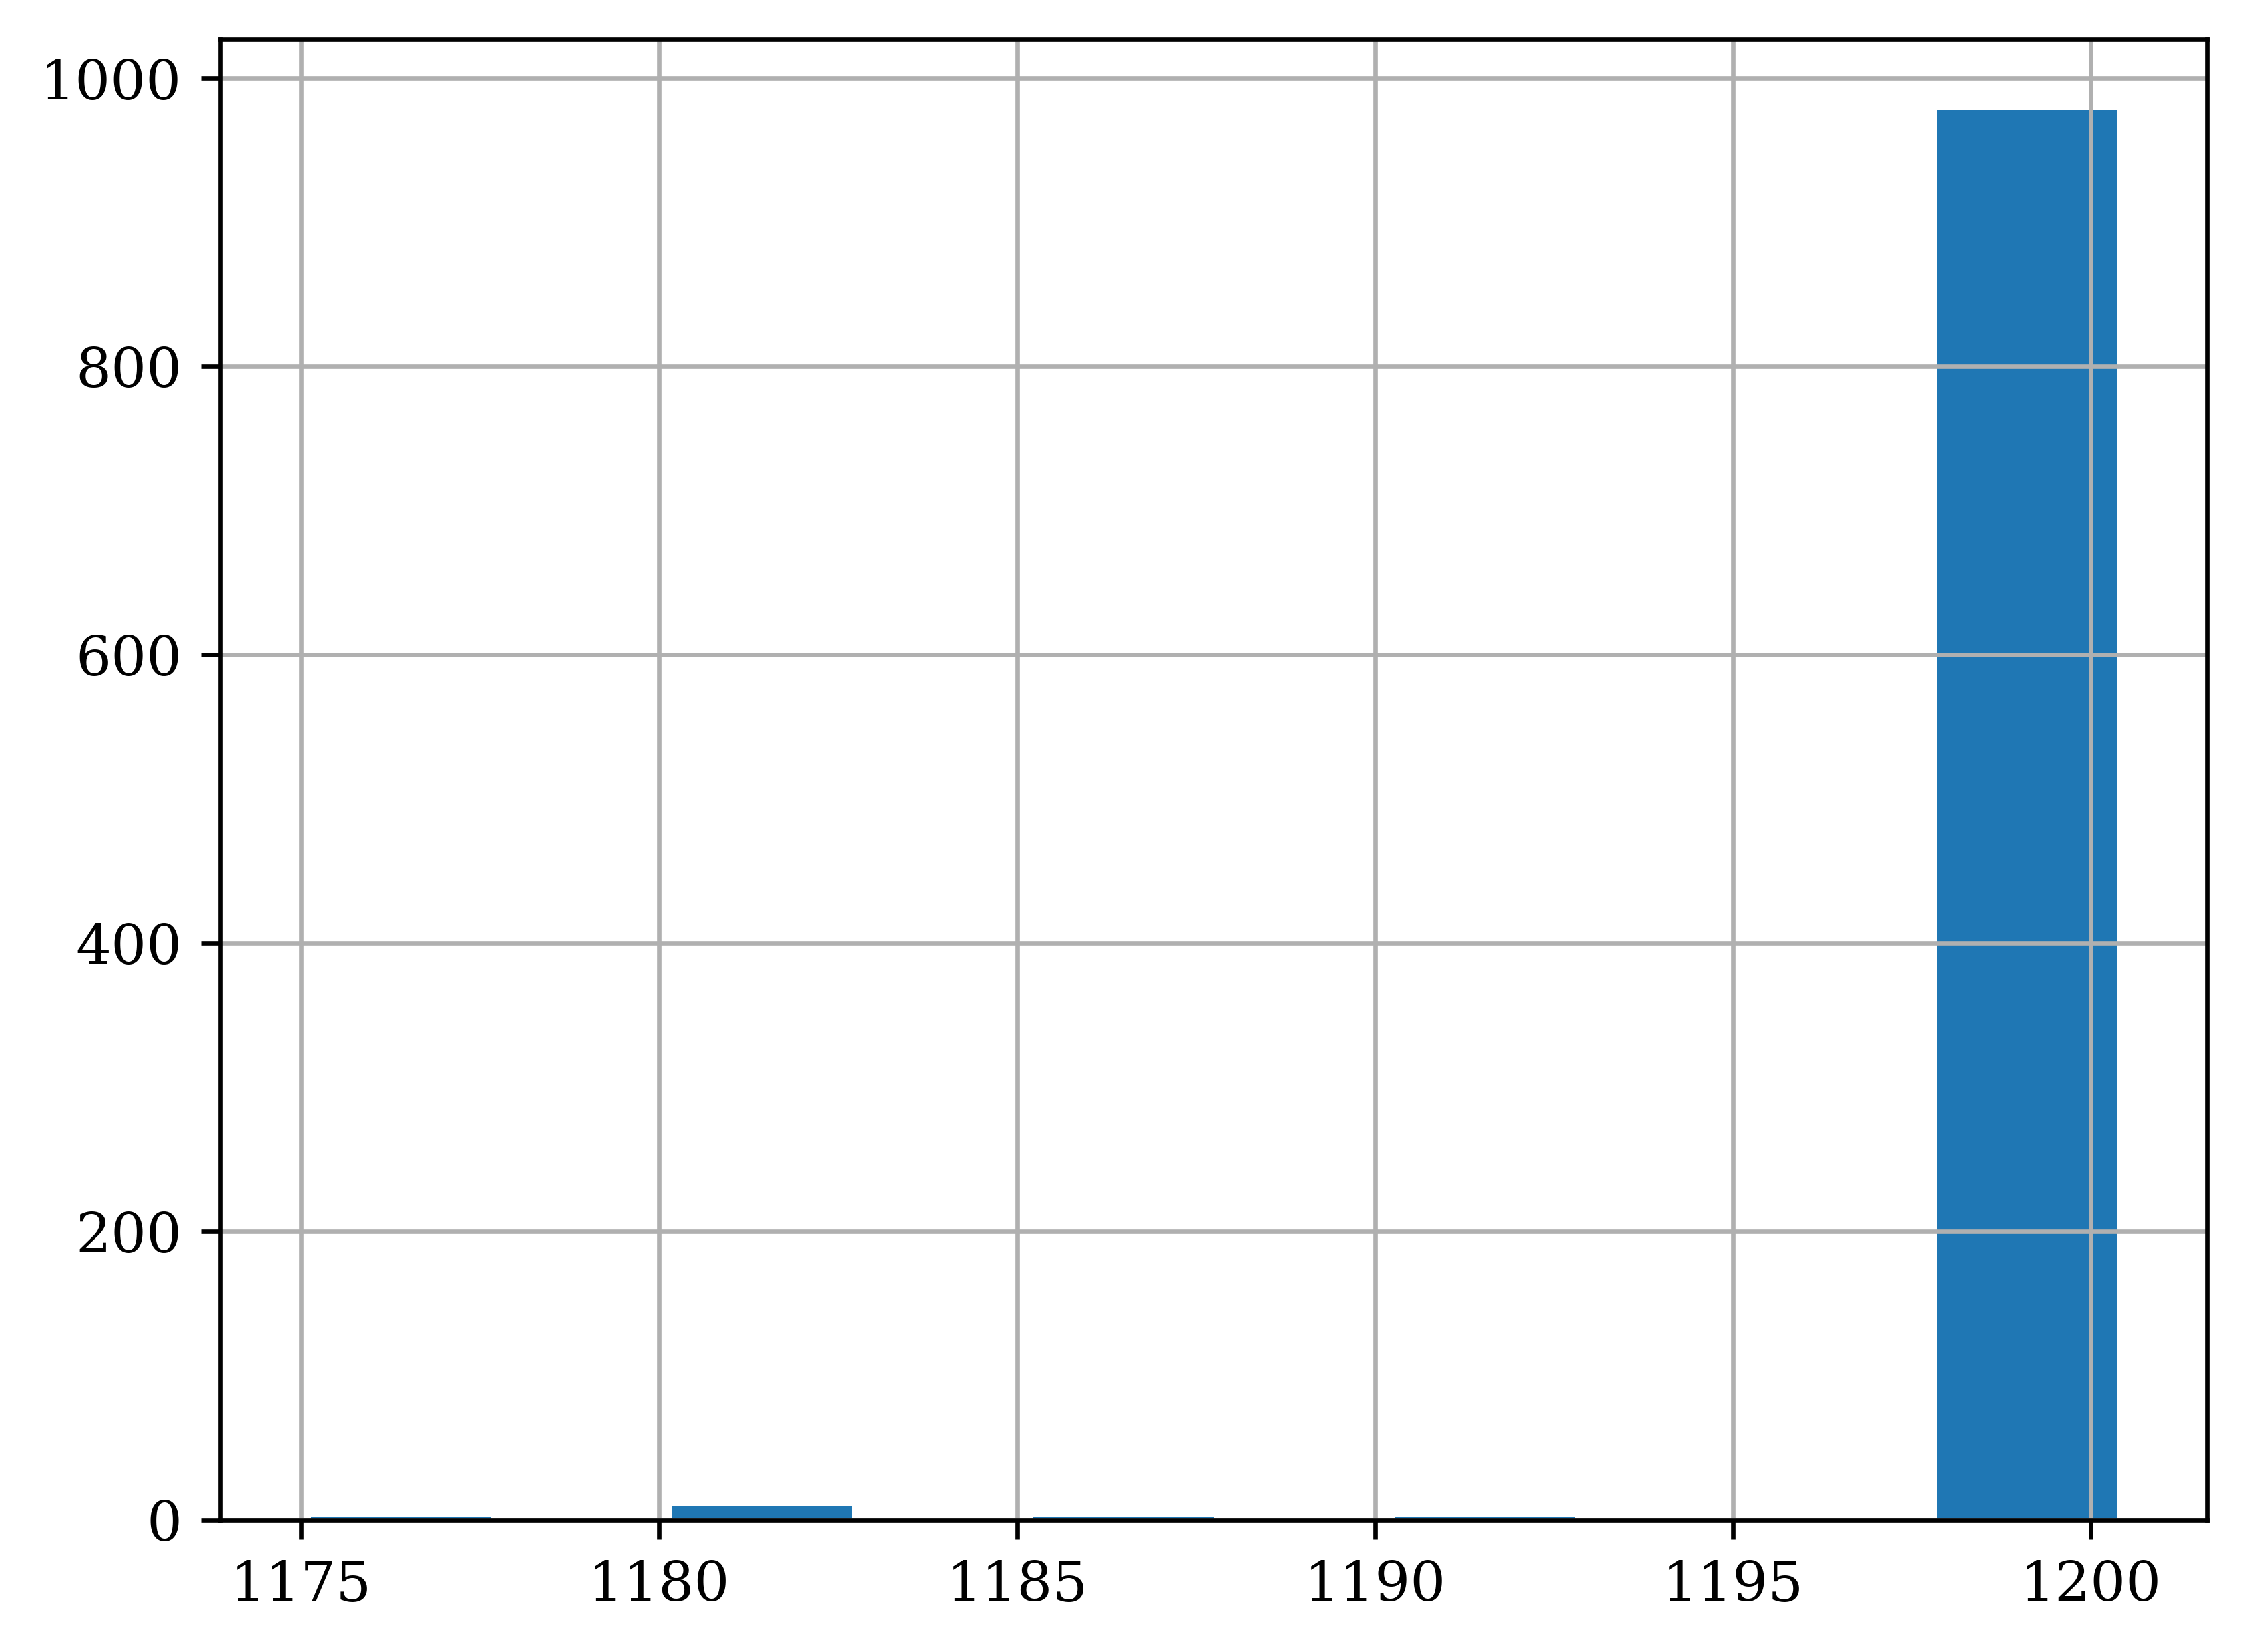

In [12]:
# after removing sessions
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
session_length.hist()

## get mouse names

In [57]:
# calculate mouse identity
df["mouse"] = df["subject_name"].str.lower().map(mouse_map)

In [58]:
np.sort(df["mouse"].unique())

array(['', '01_01', '01_02', '01_03', '01_04', '02_01', '02_02', '02_03',
       '02_04', '03_01', '03_02', '03_03', '03_04', '04_01', '04_02',
       '04_03', '04_04'], dtype=object)

In [59]:
## keep only mice that are part of the male experiment
df = df[(df["mouse"] != "") & ~df["date"].isin(exclude_dates)].reset_index()

In [64]:
# calculate usage
usage_df = (
    df.query("onsets")
    .groupby(["age", "uuid", "mouse", "subject_name", "date"])["relabeled_syllables"]
    .value_counts(normalize=True)
)
usage_df.name = "usage"
usage_df = usage_df.reset_index()

In [65]:
## remove sessions were a syllable occours more than x% of time
thresh = 0.2
syll_usage = usage_df.groupby("uuid", sort=False)["usage"].max()
remove_uuids = syll_usage[syll_usage > thresh].to_frame().reset_index()["uuid"]
usage_df = usage_df[~usage_df["uuid"].isin(remove_uuids)]

In [78]:
df = df[~df["uuid"].isin(remove_uuids)].copy()

## Compute just usage

In [68]:
# calculate usage
usage_df = (
    df.query("onsets")
    .groupby(["age", "uuid", "mouse", "subject_name", "date"])["relabeled_syllables"]
    .value_counts(normalize=True)
)
usage_df.name = "usage"
usage_df = usage_df.reset_index()

In [69]:
# find ages where less than 9 data points exists and filter them out (not sure we want that)
temp = (
    usage_df.pivot_table(
        values="usage",
        columns="relabeled_syllables",
        index=["age", "uuid", "subject_name", "date"],
    )
    .fillna(0)
    .reset_index()
)

<Axes: xlabel='age'>

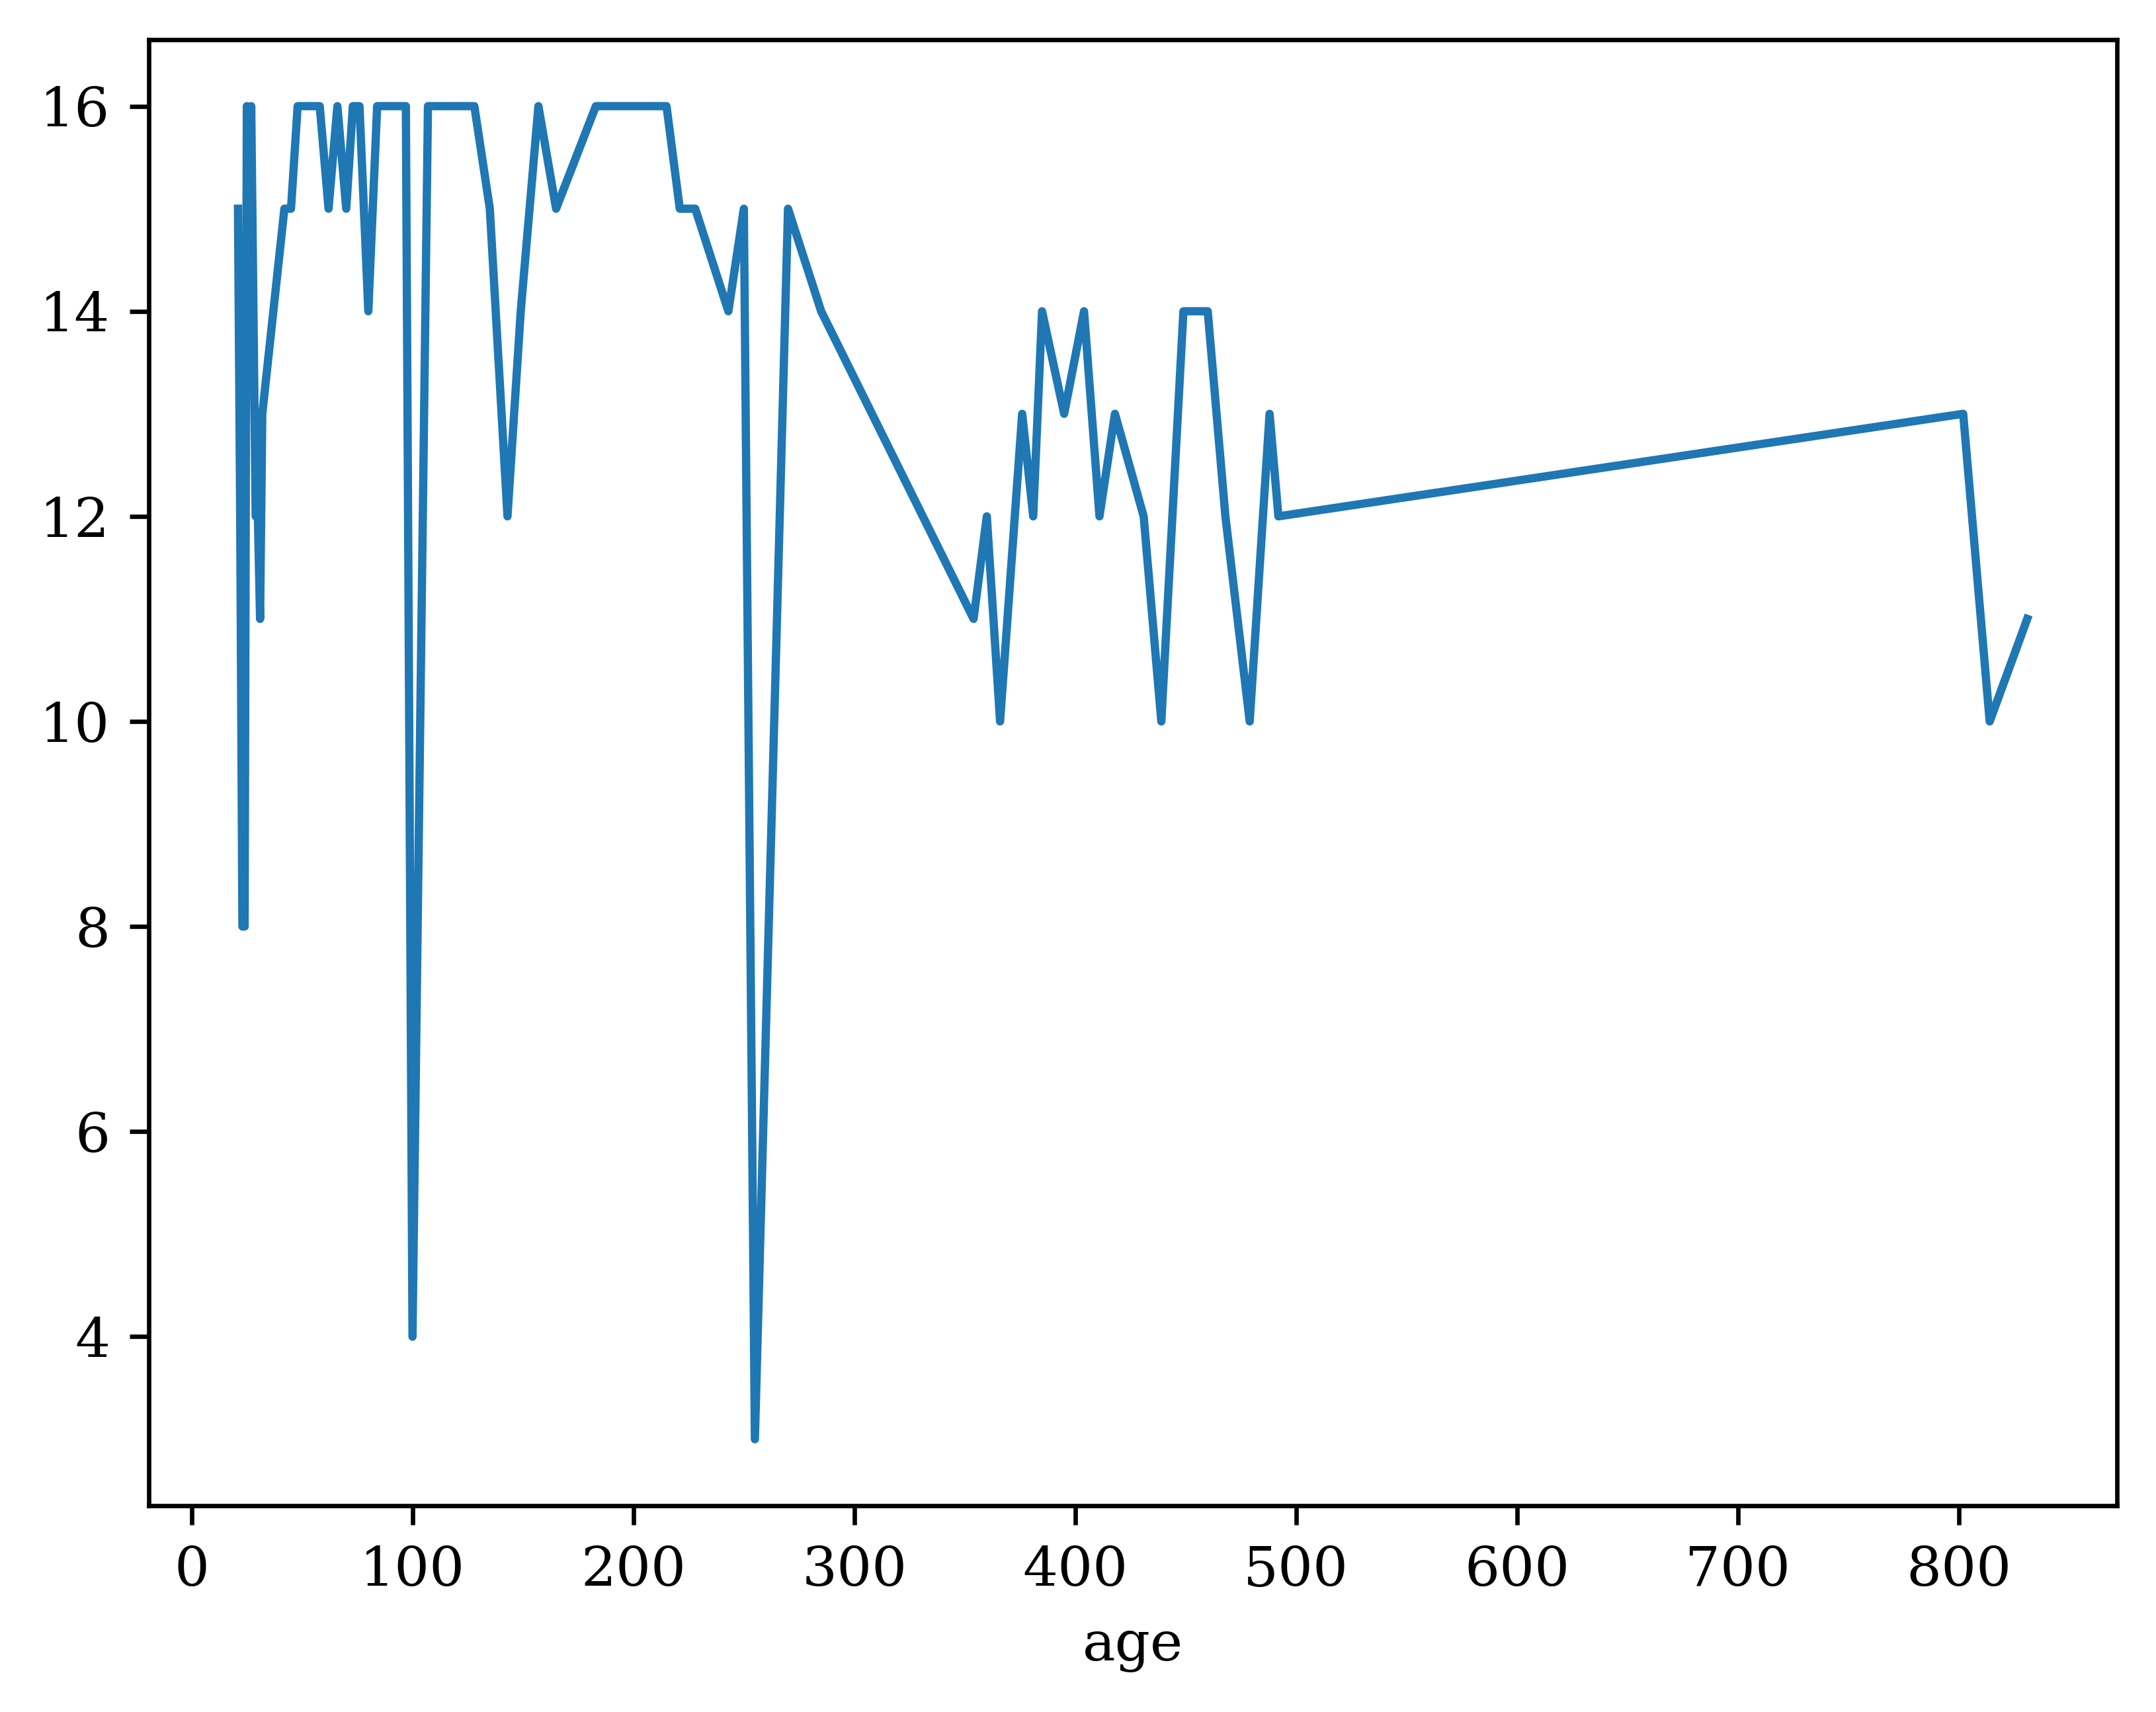

In [70]:
temp.groupby("age")["age"].count().plot()

In [23]:
# counter = Counter(temp["age"])
# thresh = 9
# remove_sessions = [k for k, v in counter.items() if v < thresh]
# usage_df = usage_df[~usage_df["age"].isin(remove_sessions)]

In [71]:
# define cage
usage_df["cage"] = usage_df.mouse.str[:2]

# some tests

In [72]:
# figure out if male and female data mixed by checking if for similar age we have a different session number
# calculate usage
temp = (
    usage_df.pivot_table(
        values="usage",
        columns="relabeled_syllables",
        index=["age", "uuid", "subject_name", "date"],
    )
    .fillna(0)
    .reset_index()
)

ages = temp.age.unique()
for age in ages:
    curr = temp[temp.age == age]
    sessions = curr.subject_name.str[-3:]  # get session number
    if len(sessions.unique()) > 1:  # if the same age has different session numbers
        curr_print = curr[["subject_name", "age", "date"]]
        print(curr_print)
        print(len(curr_print))

relabeled_syllables subject_name  age                date
27                     04_02_023   23 2021-04-01 16:54:55
28                     02_02_023   23 2021-04-01 15:28:56
29                      01_01_23   23 2021-04-01 14:48:07
30                      02_01_23   23 2021-04-01 15:28:49
31                      03_01_23   23 2021-04-01 16:10:58
32                     03_02_023   23 2021-04-01 16:11:07
33                     01_02_023   23 2021-04-01 14:48:19
34                      04_01_23   23 2021-04-01 16:54:47
8
relabeled_syllables subject_name  age                date
43                     02_01_025   25 2021-04-03 15:52:36
44                   01_03_025_1   25 2021-04-03 18:48:02
45                   02_02_025_1   25 2021-04-03 18:20:11
46                     04_01_025   25 2021-04-03 17:46:19
47                     02_04_025   25 2021-04-03 15:52:59
48                     04_02_025   25 2021-04-03 17:46:30
49                     04_03_025   25 2021-04-03 17:46:45
50          

In [73]:
# check number of sessions per age
temp = (
    usage_df.pivot_table(
        values="usage",
        columns="relabeled_syllables",
        index=["age", "uuid", "subject_name", "date"],
    )
    .fillna(0)
    .reset_index()
)
counter = Counter(temp["age"])
counter

Counter({25: 16,
         27: 16,
         48: 16,
         55: 16,
         58: 16,
         66: 16,
         73: 16,
         76: 16,
         84: 16,
         87: 16,
         90: 16,
         93: 16,
         97: 16,
         107: 16,
         114: 16,
         121: 16,
         128: 16,
         157: 16,
         183: 16,
         194: 16,
         199: 16,
         206: 16,
         215: 16,
         21: 15,
         42: 15,
         45: 15,
         62: 15,
         70: 15,
         135: 15,
         165: 15,
         221: 15,
         228: 15,
         250: 15,
         270: 15,
         26: 14,
         28: 14,
         80: 14,
         149: 14,
         243: 14,
         285: 14,
         385: 14,
         404: 14,
         449: 14,
         460: 14,
         32: 13,
         376: 13,
         395: 13,
         418: 13,
         488: 13,
         802: 13,
         22: 12,
         29: 12,
         30: 12,
         143: 12,
         360: 12,
         381: 12,
         411: 12,

## exclude uuids

## save dataframe

In [25]:
usage_mtx = usage_df.pivot_table(
    values="usage",
    columns="relabeled_syllables",
    index=["age", "mouse", "cage", "uuid", "subject_name", "date"],
).fillna(0)
usage_mtx.to_parquet(data_folder / "longtogeny_males_clean.parquet", engine="pyarrow")

## Compute within-session usage dynamics

In [81]:
bins = np.linspace(0, 1200, 21, dtype=int)

df["cut1"] = pd.cut(df["timestamps"], bins[::2], labels=False, include_lowest=True) * 2
df["cut2"] = (
    pd.cut(df["timestamps"], bins[1::2], labels=False, include_lowest=True) * 2 + 1
)

usage_dynamics1 = (
    df.query("onsets")
    .dropna(subset=["cut1"])
    .groupby(["age", "mouse", "uuid", "subject_name", "date", "cut1"])[
        "relabeled_syllables"
    ]
    .value_counts(normalize=True)
)
usage_dynamics2 = (
    df.query("onsets")
    .dropna(subset=["cut2"])
    .groupby(["age", "mouse", "uuid", "subject_name", "date", "cut2"])[
        "relabeled_syllables"
    ]
    .value_counts(normalize=True)
)

usage_dynamics1.index.rename("bin", level="cut1", inplace=True)
usage_dynamics2.index.rename("bin", level="cut2", inplace=True)

combined = pd.concat([usage_dynamics1, usage_dynamics2])
combined.name = "usage"
combined = combined.reset_index()
usage_mtx = combined.pivot_table(
    values="usage",
    columns=["relabeled_syllables", "bin"],
    index=["age", "mouse", "uuid", "subject_name", "date"],
).fillna(0)

In [82]:
usage_mtx.to_parquet(
    data_folder / "longtogeny_males_session_dynamics_clean.parquet", engine="pyarrow"
)